In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
import tensorflow as tf
import math

In [2]:
trainset = pd.read_csv("mnist_train.csv")

FileNotFoundError: File b'mnist_train.csv' does not exist

In [ ]:
testset = pd.read_csv("mnist_test.csv")

In [3]:
print(trainset.shape)
print(testset.shape)

# split dataset into tainset and cross-validation set
#trainset, valset= train_test_split(trainset, test_size = 0.1)

# get pix from trainset
x_train = trainset.iloc[:, 1 : 785]
x_train = x_train.values
# get label from trainset
y_train = trainset.loc[:,"label"]
y_train = pd.get_dummies(y_train).values

# get pix from valset
x_cv = testset.iloc[:, 1 : 785]
x_cv = x_cv.values
# get label from valset
y_cv = testset.loc[:,"label"]
y_cv = pd.get_dummies(y_cv).values

x_test = testset.values
train_arr = []
test_arr = []
cost_arr = []
#epoch =30

print("Number of training examples: " + str(x_train.shape[1]))
print("Number of cross-validation examples = " + str(x_cv.shape[1]))
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("y_train sample0: " + str(y_train[0]))
print ("x_test shape: " + str(x_test.shape))

NameError: name 'trainset' is not defined

In [120]:
def network(x_shape, y_shape, mode=tf.estimator.ModeKeys.TRAIN):
    ops.reset_default_graph()      # reset computation graph
    """
    x_shape: input dim
    y_shape: output dim
    """
    x = tf.placeholder(tf.float32, shape=(None, x_shape), name="x")
    y = tf.placeholder(tf.float32, shape=(None, y_shape), name="y")
    
    # flatten the input
    print(x)
    m = tf.layers.dense(x, units=256, activation='relu',
                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                        bias_initializer=tf.zeros_initializer())
    print(m)
    m = tf.layers.dropout(inputs=m, rate=0.1)
    print(m)
    m = tf.layers.dense(m, units=128, activation='relu',
                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                        bias_initializer=tf.zeros_initializer())
    print(m)
    m = tf.layers.dropout(inputs=m, rate=0.1)
#     print(m)
    m = tf.layers.dense(m, units=64, activation='relu', 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                        bias_initializer=tf.zeros_initializer())
    print(m)
    m = tf.layers.dropout(inputs=m, rate=0.1)
#     print(m)
    m = tf.layers.dense(m, units=32, activation='relu', 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                        bias_initializer=tf.zeros_initializer())
    print(m)
    m = tf.layers.dropout(inputs=m, rate=0.1)
#     print(m)
    m = tf.layers.dense(m, units=16, activation='relu', 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                        bias_initializer=tf.zeros_initializer())
    print(m)
    m = tf.layers.dropout(inputs=m, rate=0.1)
#     print(m)
    prediction = tf.layers.dense(m, units=y_shape, name="p", 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                        bias_initializer=tf.zeros_initializer())
    print(prediction)
    
    return x, y, prediction

def optimization(logits, labels):
    """
    logits: pred value
    labels: real value
    """
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    optim = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
#     optim = tf.contrib.opt.NadamOptimizer(learning_rate=1e-4).minimize(loss)
    return loss, optim

def random_mini_batches(x, y, mini_batch_size = 64):
    m = x.shape[0]
    mini_batches = []
    
    #shuffle x and y
    permutation = list(np.random.permutation(m))
    shuffled_x = x[permutation]
    shuffled_y = y[permutation]
    
    #partition
    num_complete_minibatches = math.ceil(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_x = shuffled_x[k*mini_batch_size : k*mini_batch_size + mini_batch_size]
        mini_batch_y = shuffled_y[k*mini_batch_size : k*mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    return mini_batches

def train(x_train, y_train, x_cv, y_cv, x_test, num_epochs, mini_batch_size = 64):
    x_shape = x_train.shape
    y_shape = y_train.shape
    print("input: ", x_shape[1], " output: ", y_shape[1])
    x, y, pred = network(x_shape[1], y_shape[1])
    # loss, optim
    loss, optim = optimization(pred, y)
    # acc 
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # init tensorflow
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)  #initializes the variables created
        for epoch in range(num_epochs):
            epoch_cost = 0
            epoch_acc = 0
            num_minibatches = math.ceil(x_shape[0]/mini_batch_size)
            minibatches = random_mini_batches(x_train, y_train)
            for minibatch in minibatches:
                (minibatch_x, minibatch_y) = minibatch
                _, minibatch_cost, p, minibatch_acc  = sess.run([optim, loss, pred, accuracy], feed_dict = {x: minibatch_x, y: minibatch_y})
                # print("pred shape: ", p)
                epoch_cost += minibatch_cost / num_minibatches
                epoch_acc += minibatch_acc / num_minibatches
                
            print("cost after epoch %i :  %.3f" % (epoch + 1, epoch_cost), end="")
            print("  train accuracy   :  %.3f" % epoch_acc)
            print("  cv accuracy   :  %.3f" % (accuracy.eval({x: x_cv, y: y_cv})))
            train_arr.append(epoch_acc)
            test_arr.append(accuracy.eval({x: x_cv, y: y_cv}))
            cost_arr.append(epoch_cost)
            
        print("network trained")
        predicts = tf.argmax(pred, 1).eval({x:x_test})
        probs = tf.nn.softmax(pred, 1).eval({x: x_test})
        print("test shape: ", x_test.shape)
        print("predicts shape: ", predicts.shape)
        print("predicts val: ", predicts)
        return predicts, probs

In [121]:

preds , probs = train(x_train, y_train, x_cv, y_cv, x_test, num_epochs=15)

input:  785  output:  10
Tensor("x:0", shape=(?, 785), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 256), dtype=float32)
Tensor("dropout/Identity:0", shape=(?, 256), dtype=float32)
Tensor("dense_1/Relu:0", shape=(?, 128), dtype=float32)
Tensor("dense_2/Relu:0", shape=(?, 64), dtype=float32)
Tensor("dense_3/Relu:0", shape=(?, 32), dtype=float32)
Tensor("dense_4/Relu:0", shape=(?, 16), dtype=float32)
Tensor("p/BiasAdd:0", shape=(?, 10), dtype=float32)
cost after epoch 1 :  0.154  train accuracy   :  0.836
  cv accuracy   :  0.940
cost after epoch 2 :  0.034  train accuracy   :  0.951
  cv accuracy   :  0.956
cost after epoch 3 :  0.023  train accuracy   :  0.966
  cv accuracy   :  0.961
cost after epoch 4 :  0.019  train accuracy   :  0.973
  cv accuracy   :  0.968
cost after epoch 5 :  0.017  train accuracy   :  0.975
  cv accuracy   :  0.964
cost after epoch 6 :  0.015  train accuracy   :  0.977
  cv accuracy   :  0.967
cost after epoch 7 :  0.013  train accuracy   :  0.981
  cv acc

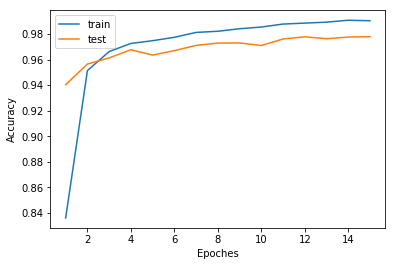

In [122]:
import matplotlib.pyplot as plt
num_epochs =15
plt.plot(range(1,num_epochs+1),train_arr,label='train')
plt.plot(range(1,num_epochs+1),test_arr,label='test')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

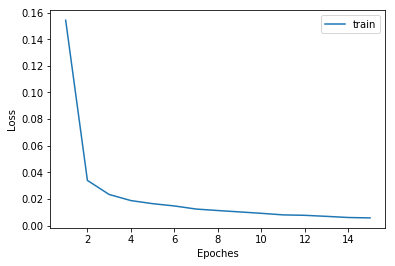

In [123]:
plt.plot(range(1,num_epochs+1),cost_arr,label='train')
#plt.plot(range(1,num_epochs+1),test_arr,label='test')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()